In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold


PERCENTILES = [1, 5, 10, 15, 20] # Top 1%, 5%, 10%, 15%, 20% of predictions
ITERATIONS = 100  # Bootstrap iterations
COLORS = ['#323694', '#039573', '#feea2a'] # Color palette for the classifiers


# CMIM ranking of features 
CMIM_SC_NO_GENPROT = ['paralagous_count', 'upstream_size',  'CAI', 'GLU',
                'aromaticity_score', 'Gravy_score', 'downstream_size',
               'PI', 'MET', 'ASP', 'GLN',  'LYS', 'FOP_score', 'ARG',  'Codon_bias']

CMIM_SC_GENPROT = ['phyletic_retention', 'paralagous_count', 'upstream_size',  'GLU', 'Codon_bias',
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size',
               'PI', 'MET', 'ASP', 'GLN',  'LYS', 'FOP_score', 'ARG']

CMIM_SC_ALL = ['phyletic_retention', 'paralagous_count', 'DIP_degree', 'nucleolus',
                'nucleus', 'upstream_size', 'spindle pole', 'GLU', 'Codon_bias',
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size',
                'vacuole', 'endosome', 'mitochondrion', 'PI', 'cytoplasm',
                'promoter_count(Harbison_et_al)', 'vacuolar membrane', 'MET', 'ASP',
                'ER to Golgi', 'GLN', 'peroxisome', 'num places loc', 'LYS',
                'ambiguous', 'cell periphery', 'FOP_score', 'nuclear periphery', 'ARG',
                'Golgi to ER', 'punctate composite', 'ER', 'lipid particle', 'microtubule',
                'Golgi', 'bud neck', 'actin', 'bud', 'Golgi to Vacuole']


CIMIM_EC_GENPROT = [
    "phyletic_retention", "Ser", "Trp", "paralog count", "Leu", "orf size", 
    "Thr", "Cys", "Gln", "Phe", "Pro", "CAI", "Ile", "Tyr", "His", 
    "Asn", "strand bias", "Gly", "Asp", "Fop", "Aromaticity", "Val", "Ala", 
    "Lys", "Glu", "CBI", "Met", "Arg"
]

CIMIM_EC_NO_GENPROT = [
    "Ser", "CAI", "Trp", "paralog count", "Leu", "orf size", "strand bias", 
    "Thr", "Cys", "Gln", "Phe", "Pro", "Ile", "Tyr", "His", "Asn", "Gly", 
    "Asp", "Fop", "Aromaticity", "Val", "Ala", "Lys", "Glu", "CBI", "Met", "Arg"
]






## `EssentiallyClassifier` Class

The `EssentiallyClassifier` class is an abstract base class designed to be implemented by diffent classifiers algorithms provviding a common interface for all classifiers.

In [2]:

class EssentiallyClassifier:
    """
    Abstract class for the essentiality classifier.
    Contains the main methods to load the data, find the optimal number of features and plot the results.
    """

    def __init__(self, file_path, cmim_ranking, percentiles,name, skip_discretization=False):
        self.name = name # Name of classifier
        self.file_path = file_path # Path to the excel file
        self.cmim_ranking = cmim_ranking # CMIM ranking of features 
        self.percentiles = percentiles # Top percentiles 
        self.X = None # Features
        self.y = None # Labels of Grand truth
        self.optimal_features = None # Optimal number of features to use
        self.highest_ppv_5 = 0 # Highest PPV (5%), used to find optimal number of features 
        self.final_ppv_scores = [] # Final PPV scores for the top percentiles
        self.final_fpr = [] # Final FPR scores
        self.final_tpr = [] # Final TPR scores
        self.final_auc = None # Final AUC score
        self.categories = None # Number of unique categories in the data
        self.skip_discretization = skip_discretization # Load the data without discretization


    def load_data(self):
        """
        Loads the data with the specified method.
        """
        self.load_discretized_data() if not self.skip_discretization else self.load_raw_data()


    def load_raw_data(self):
        """
        Loads the data without discretization.
        """
        data = pd.read_excel(self.file_path)
        self.X = data.drop(columns=['Essential', 'orf_id'])
        self.y = data['Essential']

        print("Row data loaded successfully, shape:", self.X.shape, self.y.shape)
        self.X.to_excel(f'./output/{self.name}_processed_features_.xlsx', index=False)
        print("Data saved successfully");

    def load_discretized_data(self):
        """
        Loads and processes discretized data from an Excel file.
        Reads data and uses a label encoder to convert symbols to integers.
        Counts the number of unique categories in the data.
        """
        discretized_data = pd.read_excel(self.file_path, sheet_name='entropy discretized')
        columns_with_symbols = discretized_data.columns[2:]
        label_encoders = {}

        for column in columns_with_symbols:
            le = LabelEncoder()
            discretized_data[column] = le.fit_transform(discretized_data[column].astype(str))
            label_encoders[column] = le

        self.X = discretized_data.drop(columns=['Essential', 'orf_id'])
        self.y = discretized_data['Essential']

        # Count the number of unique categories in the data
        min_categories = self.X.nunique()
        self.categories = min_categories  

        print("Discretized data loaded successfully, shape:", self.X.shape, self.y.shape)
        self.X.to_excel(f'./output/{self.name}_processed_features_.xlsx', index=False)
        print("Data saved successfully")



    def calculate_top_percentile_ppv(self, probabilities, true_labels):
        """
        Calculate the positive predictive value (PPV) for the top percentiles of predictions.

        Parameters:
            - probabilities: Array of predicted probabilities.
            - true_labels: Grand truth labels.
        
        Returns:
        - PPV values for each specified percentile in self.percentiles.
        """

        if len(probabilities) != len(true_labels):
            raise ValueError("Length of probabilities and true labels must be the same.")

        sorted_indices = np.argsort(probabilities)[::-1] # Sort probabilities in descending order so that the top probabilities are first
        sorted_labels = true_labels[sorted_indices] # Sort true labels according to the sorted probabilities
        ppv_percentiles = []

        for p in self.percentiles:
            n_top = int(len(sorted_labels) * (p / 100)) # Calc the number of top predictions to consider
            if n_top == 0:
                ppv_percentiles.append(0)
            else:
                top_labels = sorted_labels[:n_top]
                # def: PPV = TP / (TP + FP)
                ppv = np.sum(top_labels) / len(top_labels)
                ppv_percentiles.append(ppv)

        return ppv_percentiles


    def find_optimal_features(self):
        """
        Find the optimal number of features to use by evaluating the classifier with different number 
        of features taken ordered by CMIM ranking.
        """

        # Only features of the specific feature set 
        X_ranked = self.X[self.cmim_ranking]

        print("Starting to find optimal number of features...")

        # Iterate over all the features in the specific CMIM ranking
        for i in range(len(self.cmim_ranking), 0, -1):
            X_selected = X_ranked.iloc[:, :i]

            # Evaluate the model with the selected features
            res = self.evaluate_model(X_selected)
            ppv = res[0]
            
            ppv_1 = ppv[0] # PPV (1%)
            ppv_5 = ppv[1] # PPV (5%)
            print(f"Features: {i}, PPV (1%): {ppv_1}, PPV (5%): {ppv_5}")

            # Update the highest PPV (1%) and optimal number of features
            if ppv_5 > self.highest_ppv_5 and ppv_1 > ppv_5:
                self.highest_ppv_5 = ppv_5
                self.optimal_features = i


        # Print the results
        print("Highest PPV (5%):", self.highest_ppv_5)
        print("Optimal number of features:", self.optimal_features, self.cmim_ranking[:self.optimal_features])



    def evaluate_final_model(self):
        """
        Evaluate the final model with the optimal number of features.
        """

        if self.optimal_features is None:
            raise ValueError("Optimal number of features to use has not been found.") 

        # Use the optimal number of features found empirically
        X_optimal = self.X[self.cmim_ranking].iloc[:, :self.optimal_features]


        # Evaluate the model with the optimal number of features
        self.final_ppv_scores, self.final_fpr, self.final_tpr, self.final_auc = self.evaluate_model(X_optimal)
    
        print("Final PPV Percentiles:", self.final_ppv_scores)
        
        return self.final_ppv_scores



    def plot_ppv_results(self, ppv):
        """
        Plot the PPV results for the final model and compare with random predictions.

        Parameters:
            - ppv: Array of PPV values for the top percentiles of predictions of the classifier.
        """

        fig, ax = plt.subplots(figsize=(6, 4))
        percentiles_labels = [f'{p}%' for p in self.percentiles]
        random_ppv = [np.mean(self.y)] * len(self.percentiles)
        bar_with = 0.2

        ax.bar(np.arange(len(self.percentiles)) - bar_with / 2, ppv, bar_with, label=self.name, color='blue')
        ax.bar(np.arange(len(self.percentiles)) + bar_with / 2, random_ppv, bar_with, label='Random', color='black')
        ax.set_xlabel('Top Percentage of Predictions')
        ax.set_ylabel('PPV (%)')
        ax.set_title(f'PPV for {self.name} vs Random')
        ax.set_xticks(np.arange(len(self.percentiles)))
        ax.set_xticklabels(percentiles_labels)
        ax.set_ylim(0, 1)
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        ax.legend()
        fig.tight_layout()
        plt.show()


    def plot_final_roc_curve(self):
        """
        Plot the final ROC curve for the classifier.
        """
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(self.final_fpr, self.final_tpr, color='blue', label=self.name + f' (AUC = {self.final_auc:.2f})')
        ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve for {self.name}')
        ax.legend()
        fig.tight_layout()
        plt.show()
        


    def run(self):
        """
        Build, optimize and evaluate the classifier.
        """

        self.load_data()
        self.find_optimal_features() 
        ppvs = self.evaluate_final_model()
        self.plot_ppv_results(ppvs)
        self.plot_final_roc_curve()



    def evaluate_model(self, X_selected):
        """
        Evaluate the model with the selected features and calculate the PPV for the top percentiles of predictions.

        Parameters:
        - X_selected: Selected features to use for the model.
        
        Returns:
        - PPV values for the top percentiles of predictions.

        To be implemented by the subclass.
        """
        pass


## `EssentiallyBayesClassifier` Class

The `EssentiallyBayesClassifier` class is a specialized implementation of the `EssentiallyClassifier` abstract base class. It utilizes a Naive Bayes classifier to perform essentiality prediction tasks. 
The implementation uses the boostrapping technique.


In [3]:
class EssentiallyBayesClassifier(EssentiallyClassifier):
    """
    Naive Bayes classifier for the essentiality prediction.
    """

    def __init__(self, file_path, cmim_ranking, percentiles, name):
        super().__init__(file_path, cmim_ranking, percentiles ,name)


    def calcolate_boostrap_iteration(self, X_selected):
        """
        Helper function to calculate the single bootstrap iteration for the Naive Bayes classifier.

        Parameters:
            - X_selected: Selected features to use.

        Returns:
            - PPV values for the top percentiles of predictions.
            - FPR values of various percentiles
            - TPR values of various percentiles
        """


        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, self.y, test_size=0.5, stratify=self.y)

        selected_categories = self.categories[X_selected.columns].to_numpy()

        
        nb_classifier = CategoricalNB(min_categories=selected_categories)
        nb_classifier.fit(X_train, y_train)
        y_prob = nb_classifier.predict_proba(X_test)[:, 1]
     
        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)

        return self.calculate_top_percentile_ppv(y_prob, y_test.to_numpy()), fpr, tpr, auc

   
    # Override 
    def evaluate_model(self, X_selected):
        all_ppvs = []
        all_fpr = []
        all_tpr = []
        all_auc = []

        for _ in range(ITERATIONS):  # Bootstrap iterations
            ppv_iteration, fpr_iteration, tpr_iteration, auc_iteration = self.calcolate_boostrap_iteration(X_selected)
            all_ppvs.append(ppv_iteration)
            all_fpr.append(fpr_iteration)
            all_tpr.append(tpr_iteration)
            all_auc.append(auc_iteration)

        # Calculate the mean PPV for each percentile over all iterations
        mean_ppv = np.mean(all_ppvs, axis=0)

        # Calculate the mean FPR and TPR for each percentile over all iterations through interpolation 
        # (as the number of thresholds  can be different in each iteration)
        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr = np.zeros_like(mean_fpr) 

        for fpr, tpr in zip(all_fpr, all_tpr):
            mean_tpr += np.interp(mean_fpr, fpr, tpr) 

        mean_tpr /= ITERATIONS  


        mean_auc = np.mean(all_auc)

        # Restituiamo il PPV medio, FPR medio e TPR medio
        return mean_ppv, mean_fpr, mean_tpr, mean_auc

## `EssentialityExperiment` Class

The `EssentialityExperiment` class is designed to manage and run and compare multiple classifiers.
It inclueds methods for executing experiments, visualizing omparative tables and plots.


In [21]:
class EssentialityExperiment:
    def __init__(self, name, classifiers):
        self.name = name # Name of the experiment
        self.classifiers = classifiers # Classifiers to run and compare

    def run_experiment(self):
        """
        Runs all the classifiers and evaluates their performance.
        """

        print("-" * 80)
        print(f"Running experiment for {self.name}")
        print("Classifiers: ", [classifier.name for classifier in self.classifiers])
        print("-" * 80)


        for classifier in self.classifiers:
            print(f"Running classifier {classifier.name}")
            print("-" * 50)
            classifier.run()
    
    def plot_and_save_comparative_results(self, percentiles, colors=None):
        """
        Plot the comparative results of the classifiers.
        """

        if colors is None:
            colors = plt.cm.get_cmap('tab10').colors 

        fig, ax = plt.subplots(figsize=(6, 4))
        labels = [f'{p}%' for p in percentiles]
        x = np.arange(len(percentiles))
        bar_width = 0.1
        gap = 0.03  # Gap between bars in the same group

        # Plot the PPV scores for each classifier
        for idx, classifier in enumerate(self.classifiers):
            ax.bar(x + idx * (bar_width + gap), 
                np.array(classifier.final_ppv_scores) * 100,  
                bar_width, 
                label=classifier.name, 
                color=colors[idx % len(colors)],
                edgecolor='black', 
                linewidth=0.4)  

        # Random predictions
        random_ppv = [np.mean(self.classifiers[0].y) * 100] * len(percentiles)
        ax.bar(x + (len(self.classifiers)) * (bar_width + gap), 
            random_ppv, 
            bar_width, 
            label='Random', 
            color='black', 
            edgecolor='black', 
            linewidth=0.5)

        ax.set_xlabel('Top Percentage of Predictions')
        ax.set_ylabel('PPV (%)')
        ax.set_title(self.name)
        ax.set_xticks(x + (len(self.classifiers) / 2) * (bar_width + gap) )
        ax.set_xticklabels(labels)
        ax.set_ylim(0, 100) 
        ax.legend()
        fig.tight_layout()
        plt.show()

        # Save the plot to a file
        fig.savefig(f'./output/{self.name}_ppv_plot.png')


    def plot_and_save_comparative_table(self, colors=COLORS):
        """
        Plot a comparative table of the final PPV scores for each classifier.
        """
 
        rows = []
        for classifier in self.classifiers:
            if len(classifier.final_ppv_scores) != len(PERCENTILES):
                raise ValueError(
                    f"Inconsistent length for classifier '{classifier.name}': "
                    f"expected {len(PERCENTILES)} scores, got {len(classifier.final_ppv_scores)}."
                )
            rounded_scores = [str(round(score, 2)) for score in classifier.final_ppv_scores]
            rows.append(
                [classifier.name] + rounded_scores + [classifier.optimal_features]
            )

        # Create DataFrame
        columns = ['Classifier'] + [f'{p}%' for p in PERCENTILES] + ['Number of Features']
        table_df = pd.DataFrame(rows, columns=columns)
        table_df.set_index('Classifier', inplace=True)

        # Define a color palette for each row
        _colors = [f'{color}50' for color in colors]  # Add alpha chanel to colors
        color_map = {classifier.name: _colors[i % len(_colors)] for i, classifier in enumerate(self.classifiers)}

     
        def highlight_row(row):
            classifier = row.name
            color = color_map.get(classifier, '#FFFFFF')  
            return [f'background-color: {color};'] * len(row)

        styled_df = table_df.style.apply(highlight_row, axis=1)


        styled_df = styled_df.set_table_attributes('style="font-size: 14px; border-collapse: collapse;"')


        # Save the table to a CSV file
        table_df.to_csv(f'./output/{self.name}_ppv_table.csv')


        return styled_df


Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 42, PPV (1%): 0.9065217391304349, PPV (5%): 0.7597457627118642
Features: 41, PPV (1%): 0.9208695652173919, PPV (5%): 0.7601694915254237
Features: 40, PPV (1%): 0.9117391304347828, PPV (5%): 0.7571186440677968
Features: 39, PPV (1%): 0.9265217391304355, PPV (5%): 0.7594067796610169
Features: 38, PPV (1%): 0.9147826086956522, PPV (5%): 0.756864406779661
Features: 37, PPV (1%): 0.9169565217391303, PPV (5%): 0.760084745762712
Features: 36, PPV (1%): 0.9165217391304352, PPV (5%): 0.7567796610169488
Features: 35, PPV (1%): 0.9147826086956526, PPV (5%): 0.7615254237288137
Features: 34, PPV (1%): 0.9217391304347826, PPV (5%): 0.7590677966101694
Features: 33, PPV (1%): 0.9160869565217397, PPV (5%): 0.7583898305084747
Features: 32, PPV (1%): 0.9117391304347825, PPV (5%): 0.7602542372881358
Features: 31, PPV (1%): 0.915217391304348, PPV (5%): 0.764576271

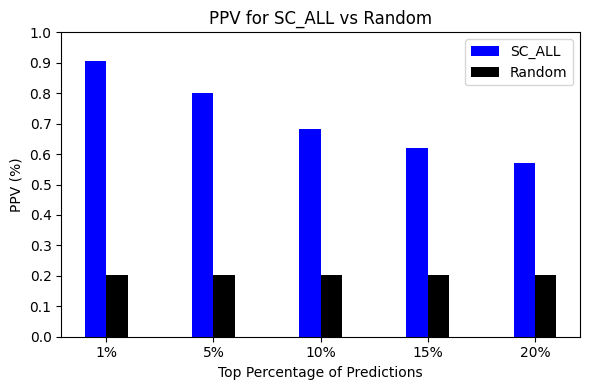

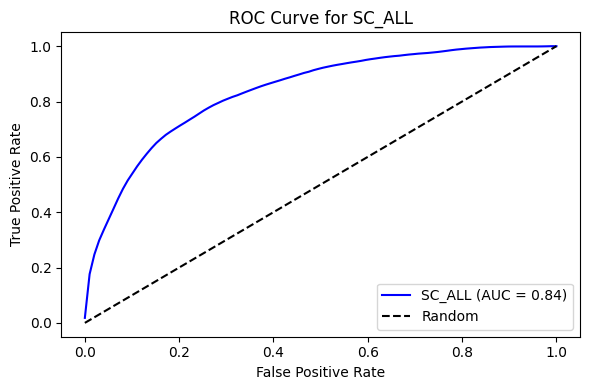

In [5]:
classifier_all = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, name='SC_ALL')
classifier_all.run()



--------------------------------------------------------------------------------
Running experiment for S. cerevisiae
Classifiers:  ['SC_ALL', 'SC_GENPROT', 'SC_NO_GENPROT']
--------------------------------------------------------------------------------
Running classifier SC_ALL
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 42, PPV (1%): 0.9313043478260876, PPV (5%): 0.757966101694915
Features: 41, PPV (1%): 0.9139130434782611, PPV (5%): 0.7557627118644068
Features: 40, PPV (1%): 0.9191304347826091, PPV (5%): 0.7563559322033897
Features: 39, PPV (1%): 0.9213043478260872, PPV (5%): 0.7631355932203391
Features: 38, PPV (1%): 0.9169565217391309, PPV (5%): 0.7590677966101693
Features: 37, PPV (1%): 0.9186956521739138, PPV (5%): 0.7561016949152541
Features: 36, PPV (1%): 0.9160869565217392, PPV (5%): 0.7592372881355933
Features: 35, PPV (1%):

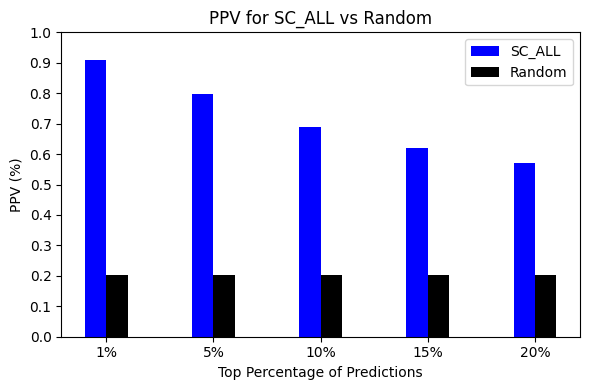

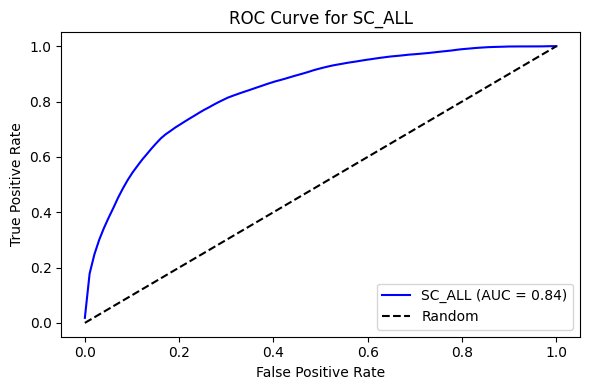

Running classifier SC_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 16, PPV (1%): 0.8208695652173909, PPV (5%): 0.6588983050847458
Features: 15, PPV (1%): 0.8243478260869562, PPV (5%): 0.6772033898305087
Features: 14, PPV (1%): 0.8139130434782609, PPV (5%): 0.6682203389830508
Features: 13, PPV (1%): 0.8160869565217388, PPV (5%): 0.672966101694915
Features: 12, PPV (1%): 0.8326086956521737, PPV (5%): 0.692627118644068
Features: 11, PPV (1%): 0.8330434782608697, PPV (5%): 0.7140677966101694
Features: 10, PPV (1%): 0.847826086956522, PPV (5%): 0.7177118644067797
Features: 9, PPV (1%): 0.8578260869565214, PPV (5%): 0.698813559322034
Features: 8, PPV (1%): 0.8504347826086951, PPV (5%): 0.6972881355932204
Features: 7, PPV (1%): 0.8147826086956523, PPV (5%): 0.6898305084745764
Features: 6, PPV (1%): 0.8317391304347818, PPV (5%): 0.688474

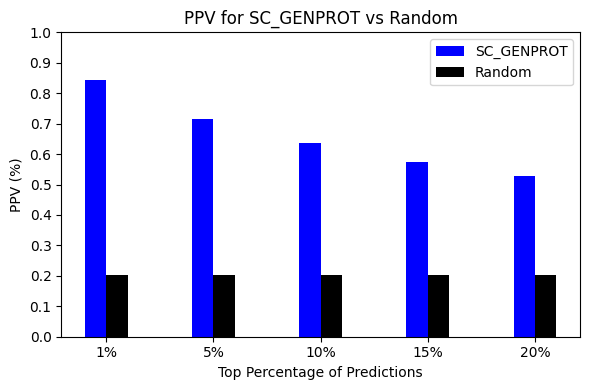

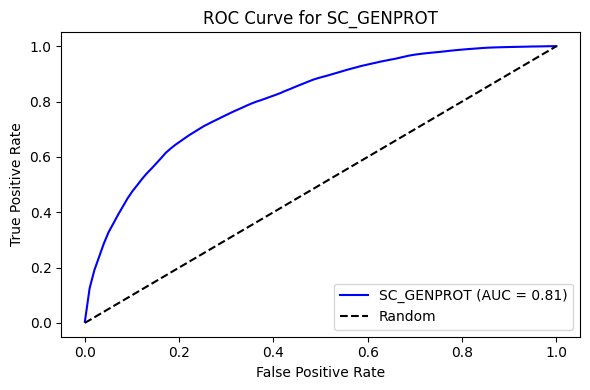

Running classifier SC_NO_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 15, PPV (1%): 0.6569565217391309, PPV (5%): 0.5134745762711865
Features: 14, PPV (1%): 0.5913043478260872, PPV (5%): 0.51364406779661
Features: 13, PPV (1%): 0.6169565217391311, PPV (5%): 0.5255932203389828
Features: 12, PPV (1%): 0.5643478260869571, PPV (5%): 0.45076271186440664
Features: 11, PPV (1%): 0.5482608695652176, PPV (5%): 0.4496610169491525
Features: 10, PPV (1%): 0.5260869565217391, PPV (5%): 0.45805084745762714
Features: 9, PPV (1%): 0.48999999999999994, PPV (5%): 0.5088983050847457
Features: 8, PPV (1%): 0.47347826086956524, PPV (5%): 0.5110169491525423
Features: 7, PPV (1%): 0.5404347826086958, PPV (5%): 0.5316101694915255
Features: 6, PPV (1%): 0.5300000000000001, PPV (5%): 0.535762711864407
Features: 5, PPV (1%): 0.5160869565217391, PPV (5%): 0

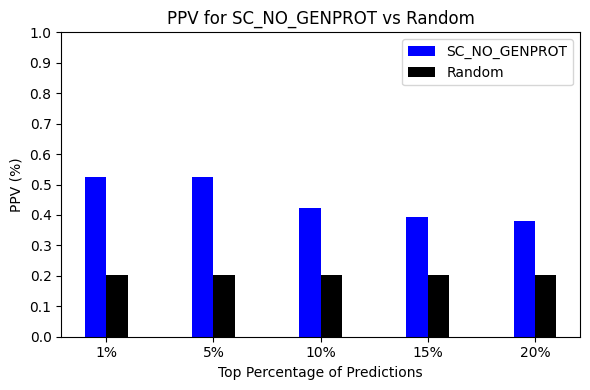

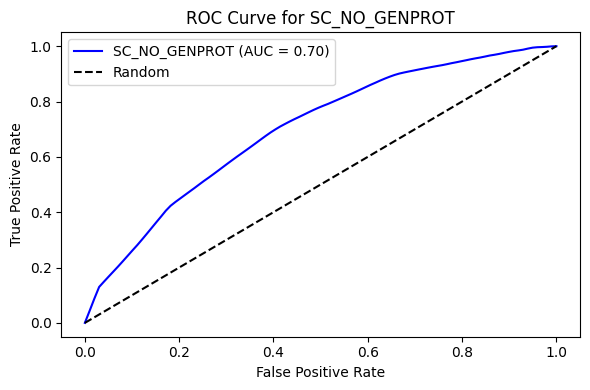

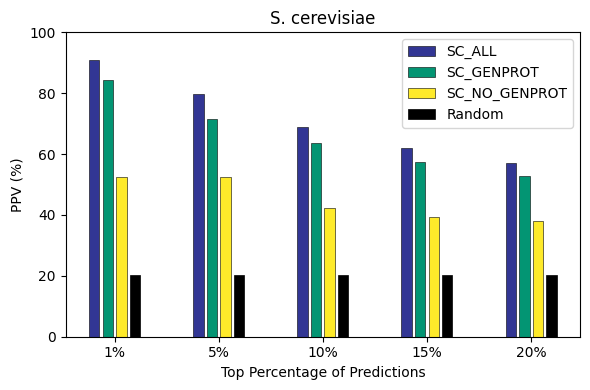

,1%,5%,10%,15%,20%,Number of Features
Classifier,,,,,,
SC_ALL,0.91,0.8,0.69,0.62,0.57,23
SC_GENPROT,0.84,0.72,0.64,0.57,0.53,10
SC_NO_GENPROT,0.52,0.52,0.42,0.39,0.38,7


In [ ]:


classifier_no_genprot_nb = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_NO_GENPROT, PERCENTILES, name='SC_NO_GENPROT')
classifier_genprot_nb = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_GENPROT, PERCENTILES, name='SC_GENPROT')
classifier_all_nb = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, name='SC_ALL')

experiment = EssentialityExperiment("S. cerevisiae - Naive Bayes", [classifier_all_nb, classifier_genprot_nb, classifier_no_genprot_nb])
experiment.run_experiment()
experiment.plot_and_save_comparative_results(PERCENTILES, colors=COLORS)
experiment.plot_and_save_comparative_table()



In [7]:
class EssentialityRandomForestClassifier(EssentiallyClassifier):
    """
    Random Forest classifier for the essentiality prediction.
    """


    def __init__(self, file_path, cmim_ranking, percentiles, name):
        super().__init__(file_path, cmim_ranking, percentiles,name, skip_discretization=False)

        self.rf_classifiers = []  # List of Random Forest classifiers for each fold

   
    # Override
    def evaluate_model(self, X_selected):

        self.rf_classifiers = []  # Reset the list of classifiers

        k_folds = 5  # Number of folds
        skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)


        all_ppv = []
        all_tpr = []
        all_auc = []
        mean_fpr = np.linspace(0,1,100)

        for train_index, test_index in skf.split(X_selected, self.y):
            X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]

            # Build and fit the Random Forest classifier
            rf_classifier = RandomForestClassifier(
                n_estimators=100,           # Number of trees
                max_depth=15,               # Maximum depth of the tree
                min_samples_leaf=5,         # Minimum samples per leaf 
                max_features='sqrt',        # Features considered for best split
                class_weight='balanced',    # Handle imbalanced classes
                n_jobs=-1                   # Use all cores (for parallel processing)
            )
            rf_classifier.fit(X_train, y_train)

            # Predict probabilities on the test set
            y_prob = rf_classifier.predict_proba(X_test)[:, 1]

            # Calculate metrics
            ppv_iteration = self.calculate_top_percentile_ppv(y_prob, y_test.to_numpy())
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            auc = roc_auc_score(y_test, y_prob)
            

            all_ppv.append(ppv_iteration)
            all_tpr.append(np.interp(mean_fpr, fpr, tpr))
            all_auc.append(auc)

            # Save the classifier 
            self.rf_classifiers.append(rf_classifier)
        
        
        mean_ppv = np.mean(all_ppv, axis=0)
        mean_tpr = np.mean(all_tpr, axis=0)
        mean_auc = np.mean(all_auc)


        return mean_ppv, mean_fpr, mean_tpr, mean_auc
    


    def plot_feature_importance(self):
        """
        Plot the feature importance of the Random Forest classifier.
        """

        # Assumiamo che self.rf_classifiers sia una lista di Random Forest usati nei vari fold
        all_importances = [clf.feature_importances_ for clf in self.rf_classifiers]

        for i, importances in enumerate(all_importances):
            print(f"Fold {i} - Feature Importances:" , len(importances), importances)


        # Converti in un array di numpy e calcola la media lungo i classificatori
        importances = np.mean(all_importances, axis=0)  
        feature_names = self.X[self.cmim_ranking].iloc[:, :self.optimal_features].columns

        plt.figure(figsize=(5, 6))  # Adjust figure size based on the number of features
        plt.barh(feature_names, importances)
        plt.xlabel("Feature Importance")
        plt.ylabel("Feature")
        plt.title(f"Feature Importance in Random Forest for {self.name}")
        plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names, va='center', fontsize=10)
        plt.tight_layout()
        plt.show()

    # Extend run method to plot feature importance
    def run(self):
        super().run()
        self.plot_feature_importance()

--------------------------------------------------------------------------------
Running experiment for S. cerevisiae Random Forest
Classifiers:  ['SC_ALL', 'SC_GENPROT', 'SC_NO_GENPROT']
--------------------------------------------------------------------------------
Running classifier SC_ALL
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 42, PPV (1%): 0.9111111111111111, PPV (5%): 0.8042553191489361
Features: 41, PPV (1%): 0.9111111111111111, PPV (5%): 0.8042553191489361
Features: 40, PPV (1%): 0.9111111111111111, PPV (5%): 0.8170212765957446
Features: 39, PPV (1%): 0.888888888888889, PPV (5%): 0.8170212765957447
Features: 38, PPV (1%): 0.9333333333333332, PPV (5%): 0.8
Features: 37, PPV (1%): 0.8666666666666666, PPV (5%): 0.8127659574468085
Features: 36, PPV (1%): 0.9333333333333332, PPV (5%): 0.8170212765957446
Features: 35, PPV (1%): 

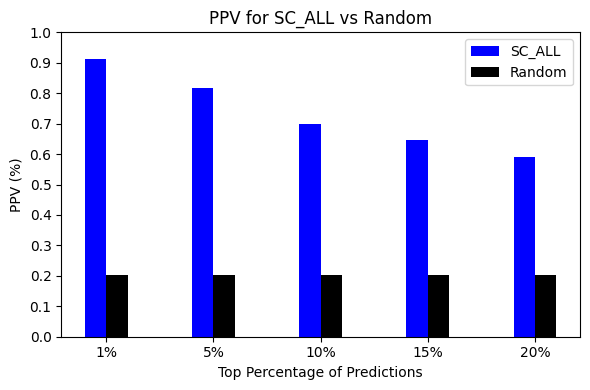

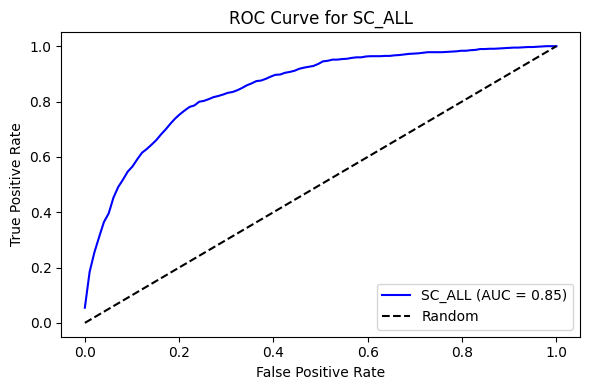

Fold 0 - Feature Importances: 39 [3.95140732e-01 6.89668540e-02 7.22107082e-02 2.75655537e-02
 4.56411753e-02 3.12227725e-02 2.28030397e-02 2.45080748e-02
 1.55146740e-02 1.71363748e-02 1.55283496e-02 3.31561372e-02
 9.50580674e-03 2.69703400e-03 1.37683013e-03 5.53160395e-03
 2.22836052e-02 3.06939669e-02 1.18924864e-02 2.71676577e-03
 1.53280089e-02 9.80643681e-03 0.00000000e+00 1.76421479e-02
 2.13569944e-04 1.65461381e-02 1.84254066e-02 4.40941531e-03
 4.28179203e-03 2.21877424e-02 3.40835802e-03 1.69271627e-02
 1.17553575e-04 2.35326978e-03 1.06129225e-02 7.25187286e-05
 4.63929033e-05 7.21152084e-05 1.45650421e-03]
Fold 1 - Feature Importances: 39 [3.87962414e-01 6.86247922e-02 8.42643928e-02 2.39510249e-02
 5.22244775e-02 4.32476035e-02 1.79411219e-02 2.43000752e-02
 1.74841221e-02 1.54532266e-02 1.32522092e-02 2.93793594e-02
 8.93688358e-03 4.33348262e-03 2.75448287e-03 4.84184284e-03
 2.14983888e-02 3.11027348e-02 1.21056731e-02 2.41885462e-03
 1.18088643e-02 1.11587436e-02 0.

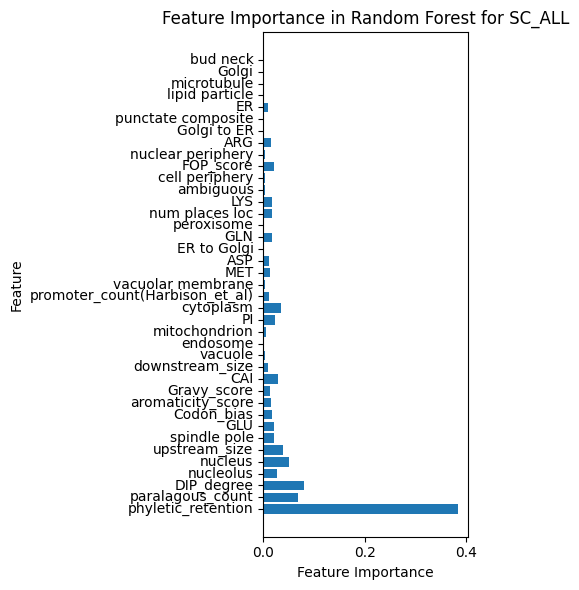

Running classifier SC_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 16, PPV (1%): 0.7777777777777778, PPV (5%): 0.727659574468085
Features: 15, PPV (1%): 0.8, PPV (5%): 0.727659574468085
Features: 14, PPV (1%): 0.8444444444444444, PPV (5%): 0.7361702127659574
Features: 13, PPV (1%): 0.8444444444444443, PPV (5%): 0.7148936170212765
Features: 12, PPV (1%): 0.8444444444444444, PPV (5%): 0.6851063829787234
Features: 11, PPV (1%): 0.8666666666666666, PPV (5%): 0.7063829787234043
Features: 10, PPV (1%): 0.8222222222222222, PPV (5%): 0.723404255319149
Features: 9, PPV (1%): 0.8666666666666666, PPV (5%): 0.7446808510638298
Features: 8, PPV (1%): 0.8444444444444443, PPV (5%): 0.7404255319148937
Features: 7, PPV (1%): 0.7999999999999999, PPV (5%): 0.7319148936170213
Features: 6, PPV (1%): 0.8444444444444443, PPV (5%): 0.727659574468085
Feat

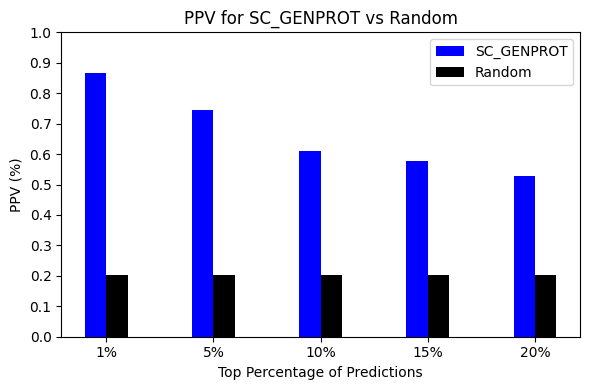

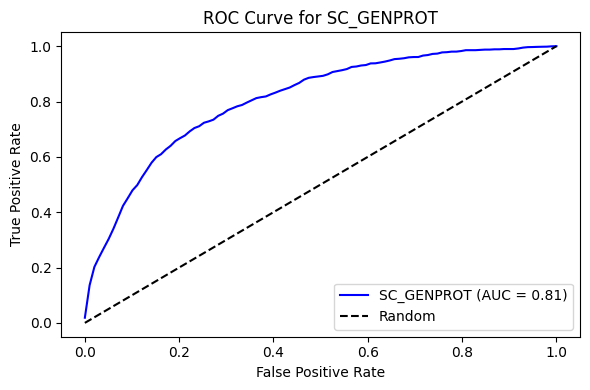

Fold 0 - Feature Importances: 9 [0.6358552  0.10839088 0.05013212 0.05240156 0.03316185 0.03307635
 0.0208884  0.04956562 0.01652801]
Fold 1 - Feature Importances: 9 [0.61968587 0.1161291  0.06396265 0.05246787 0.03141722 0.03303831
 0.0229525  0.04112164 0.01922484]
Fold 2 - Feature Importances: 9 [0.63739363 0.11690514 0.06185346 0.04614746 0.02842501 0.02872507
 0.02229128 0.03683838 0.02142057]
Fold 3 - Feature Importances: 9 [0.62227219 0.10646546 0.06033029 0.053997   0.03032736 0.03261263
 0.02202003 0.05385793 0.01811712]
Fold 4 - Feature Importances: 9 [0.60851498 0.12816541 0.07118831 0.0513843  0.02945091 0.03178927
 0.01778534 0.04183045 0.01989104]


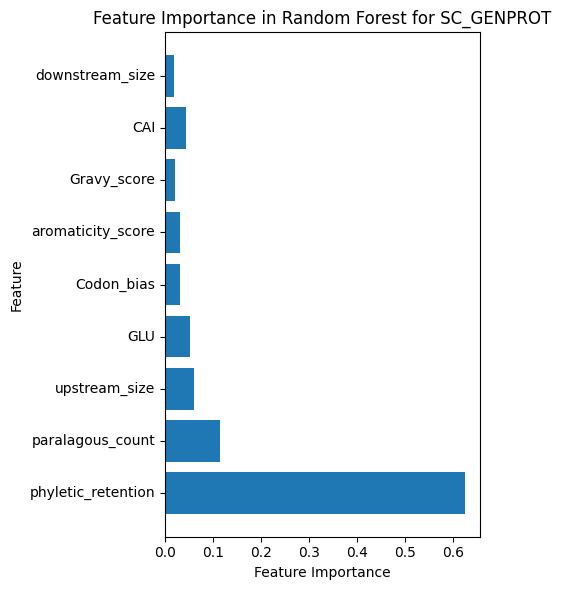

Running classifier SC_NO_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 15, PPV (1%): 0.6222222222222222, PPV (5%): 0.5319148936170212
Features: 14, PPV (1%): 0.6666666666666666, PPV (5%): 0.5191489361702126
Features: 13, PPV (1%): 0.5333333333333333, PPV (5%): 0.548936170212766
Features: 12, PPV (1%): 0.5777777777777777, PPV (5%): 0.5319148936170213
Features: 11, PPV (1%): 0.5777777777777777, PPV (5%): 0.5276595744680852
Features: 10, PPV (1%): 0.6444444444444445, PPV (5%): 0.5234042553191489
Features: 9, PPV (1%): 0.6222222222222221, PPV (5%): 0.5361702127659574
Features: 8, PPV (1%): 0.7333333333333332, PPV (5%): 0.548936170212766
Features: 7, PPV (1%): 0.5777777777777777, PPV (5%): 0.5276595744680852
Features: 6, PPV (1%): 0.6444444444444445, PPV (5%): 0.5234042553191489
Features: 5, PPV (1%): 0.5777777777777777, PPV (5%): 0.53

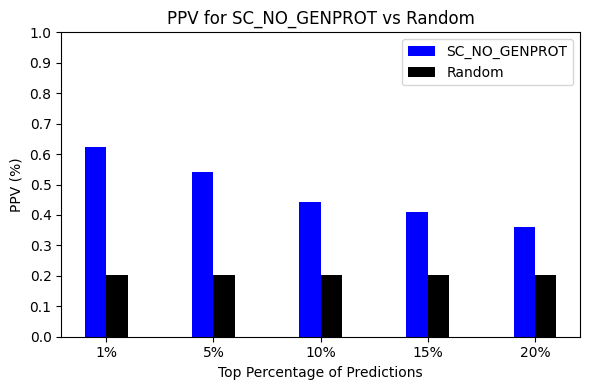

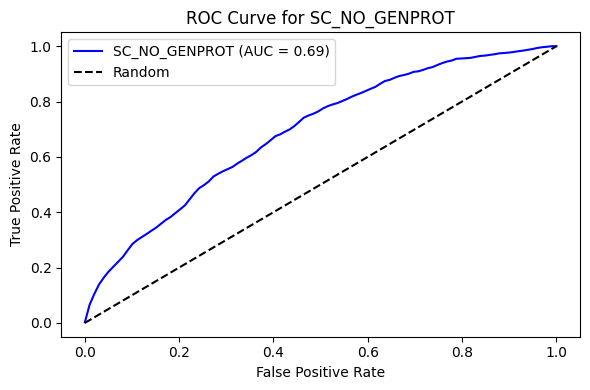

Fold 0 - Feature Importances: 8 [0.28136846 0.13948202 0.19266605 0.12333328 0.08009674 0.06795939
 0.05213328 0.06296077]
Fold 1 - Feature Importances: 8 [0.27956392 0.16627311 0.16487718 0.12190414 0.08772263 0.07006544
 0.05069697 0.05889662]
Fold 2 - Feature Importances: 8 [0.29521315 0.16488863 0.15125523 0.10218959 0.07801351 0.0777887
 0.0692556  0.06139558]
Fold 3 - Feature Importances: 8 [0.26553826 0.15714207 0.1941985  0.11000026 0.08651264 0.07819758
 0.05329201 0.05511867]
Fold 4 - Feature Importances: 8 [0.29854082 0.17757268 0.16345624 0.10651504 0.07552896 0.05773064
 0.05857179 0.06208384]


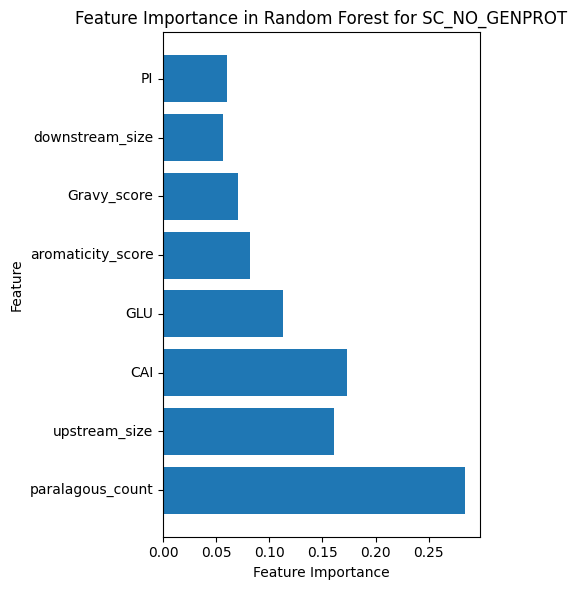

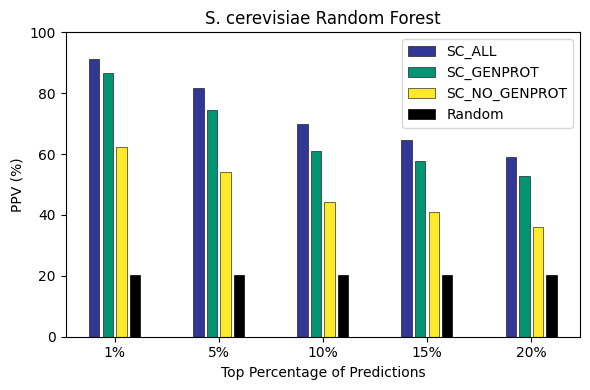

,1%,5%,10%,15%,20%,Number of Features
Classifier,,,,,,
SC_ALL,0.91,0.82,0.7,0.65,0.59,39
SC_GENPROT,0.87,0.74,0.61,0.58,0.53,9
SC_NO_GENPROT,0.62,0.54,0.44,0.41,0.36,8


In [ ]:


classifier_no_genprot_rf = EssentialityRandomForestClassifier('assets/cerevisiae_data.xls', CMIM_SC_NO_GENPROT, PERCENTILES, name='SC_NO_GENPROT')
classifier_genprot_rf = EssentialityRandomForestClassifier('assets/cerevisiae_data.xls', CMIM_SC_GENPROT, PERCENTILES, name='SC_GENPROT')
classifier_all_rf = EssentialityRandomForestClassifier('assets/cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, name='SC_ALL')

experiment = EssentialityExperiment("S. cerevisiae - Random Forest", [classifier_all_rf, classifier_genprot_rf, classifier_no_genprot_rf])

experiment.run_experiment()
experiment.plot_and_save_comparative_results(PERCENTILES, colors=['#323694', '#039573', '#feea2a'])
experiment.plot_and_save_comparative_table()




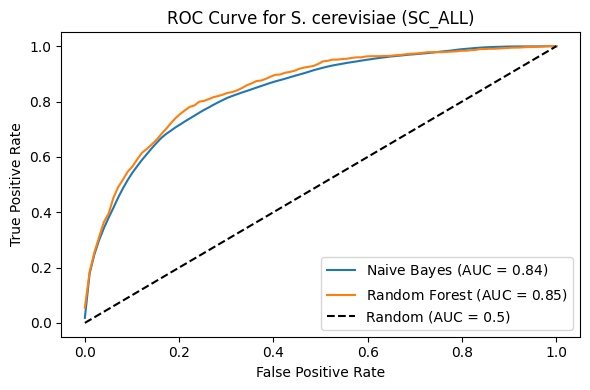

In [9]:
# Compare roc curves of naive bayes and random forest for SC_ALL
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(classifier_all_nb.final_fpr, classifier_all_nb.final_tpr, label='Naive Bayes (AUC = ${:.2f}$)'.format(classifier_all_nb.final_auc))
ax.plot(classifier_all_rf.final_fpr, classifier_all_rf.final_tpr, label='Random Forest (AUC = ${:.2f}$)'.format(classifier_all_rf.final_auc))
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random (AUC = 0.5)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for S. cerevisiae (SC_ALL)')
ax.legend()
fig.tight_layout()



# Escherichia coli

--------------------------------------------------------------------------------
Running experiment for E. coli - Naive Bayes
Classifiers:  ['EC_GENPROT', 'EC_NO_GENPROT']
--------------------------------------------------------------------------------
Running classifier EC_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (3569, 28) (3569,)
Data saved successfully
Starting to find optimal number of features...
Features: 28, PPV (1%): 0.782941176470588, PPV (5%): 0.46595505617977556
Features: 27, PPV (1%): 0.7805882352941172, PPV (5%): 0.4606741573033709
Features: 26, PPV (1%): 0.7888235294117646, PPV (5%): 0.45943820224719123
Features: 25, PPV (1%): 0.7976470588235286, PPV (5%): 0.4570786516853936
Features: 24, PPV (1%): 0.7958823529411758, PPV (5%): 0.46561797752809
Features: 23, PPV (1%): 0.8029411764705877, PPV (5%): 0.45943820224719106
Features: 22, PPV (1%): 0.7794117647058819, PPV (5%): 0.4516853932584271
Features: 21, PPV (1

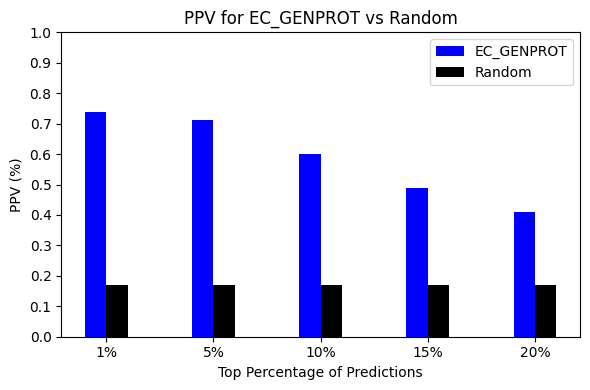

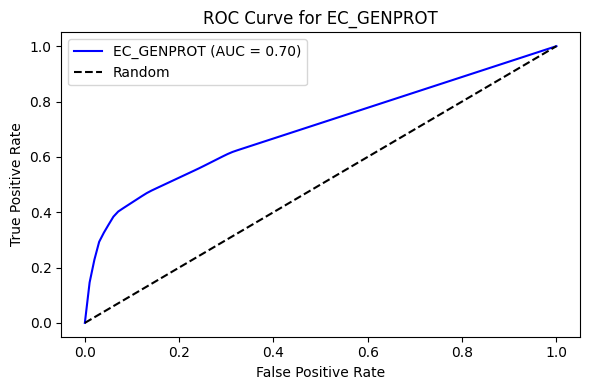

Running classifier EC_NO_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (3569, 28) (3569,)
Data saved successfully
Starting to find optimal number of features...
Features: 27, PPV (1%): 0.6988235294117642, PPV (5%): 0.40033707865168533
Features: 26, PPV (1%): 0.7364705882352941, PPV (5%): 0.40910112359550566
Features: 25, PPV (1%): 0.7194117647058818, PPV (5%): 0.41314606741573023
Features: 24, PPV (1%): 0.7270588235294116, PPV (5%): 0.39483146067415703
Features: 23, PPV (1%): 0.7435294117647053, PPV (5%): 0.4121348314606742
Features: 22, PPV (1%): 0.7441176470588233, PPV (5%): 0.4085393258426966
Features: 21, PPV (1%): 0.7329411764705879, PPV (5%): 0.40955056179775284
Features: 20, PPV (1%): 0.7388235294117642, PPV (5%): 0.4167415730337079
Features: 19, PPV (1%): 0.7476470588235293, PPV (5%): 0.42752808988764057
Features: 18, PPV (1%): 0.6952941176470583, PPV (5%): 0.4141573033707867
Features: 17, PPV (1%): 0.6694117647058822, P

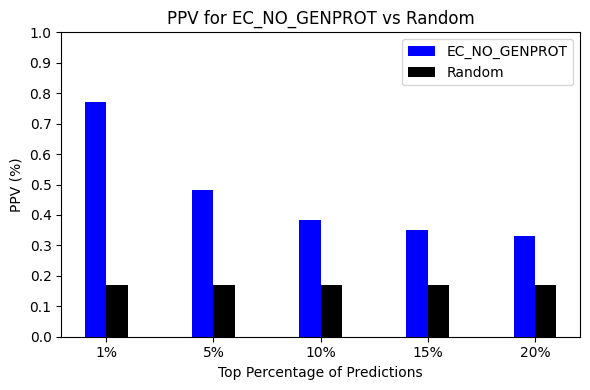

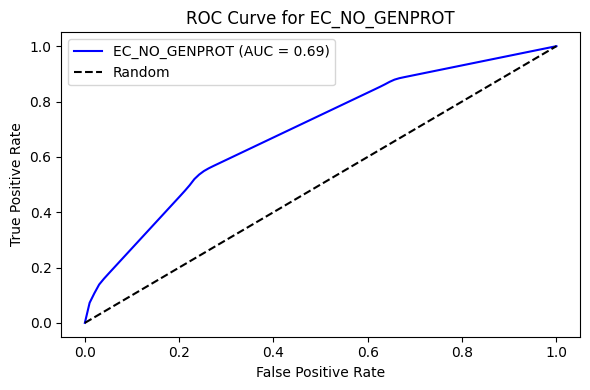

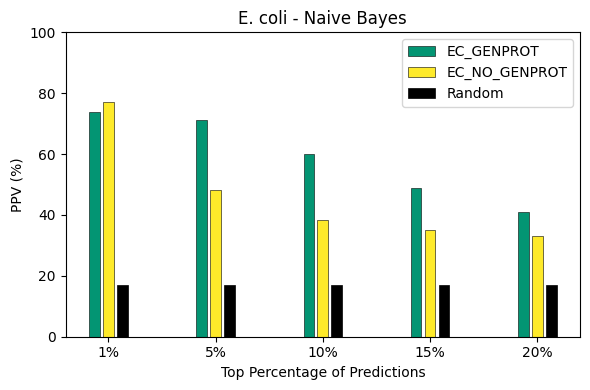

,1%,5%,10%,15%,20%,Number of Features
Classifier,,,,,,
EC_GENPROT,0.74,0.71,0.6,0.49,0.41,1
EC_NO_GENPROT,0.77,0.48,0.38,0.35,0.33,2


In [29]:
classifier_genprot_nb = EssentiallyBayesClassifier('assets/coli_data.xls', CIMIM_EC_GENPROT, PERCENTILES, name='EC_GENPROT')
classifier_no_genprot_nb = EssentiallyBayesClassifier('assets/coli_data.xls', CIMIM_EC_NO_GENPROT, PERCENTILES, name='EC_NO_GENPROT')

experiment = EssentialityExperiment("E. coli - Naive Bayes", [classifier_genprot_nb, classifier_no_genprot_nb])
experiment.run_experiment()
experiment.plot_and_save_comparative_results(PERCENTILES, colors=COLORS[1:])
experiment.plot_and_save_comparative_table(colors=COLORS[1:])

--------------------------------------------------------------------------------
Running experiment for E. coli - Random Forest
Classifiers:  ['EC_GENPROT', 'EC_NO_GENPROT']
--------------------------------------------------------------------------------
Running classifier EC_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (3569, 28) (3569,)
Data saved successfully
Starting to find optimal number of features...
Features: 28, PPV (1%): 0.6857142857142857, PPV (5%): 0.7028571428571428
Features: 27, PPV (1%): 0.7428571428571429, PPV (5%): 0.6799999999999999
Features: 26, PPV (1%): 0.7142857142857143, PPV (5%): 0.6685714285714285
Features: 25, PPV (1%): 0.7428571428571428, PPV (5%): 0.6857142857142857
Features: 24, PPV (1%): 0.7142857142857142, PPV (5%): 0.6799999999999999
Features: 23, PPV (1%): 0.7714285714285715, PPV (5%): 0.6685714285714286
Features: 22, PPV (1%): 0.7428571428571429, PPV (5%): 0.6857142857142857
Features: 21, PPV 

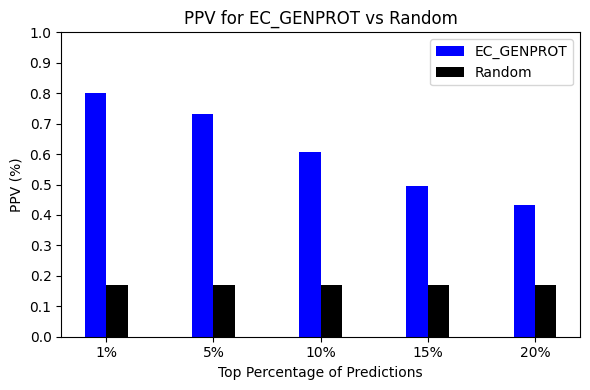

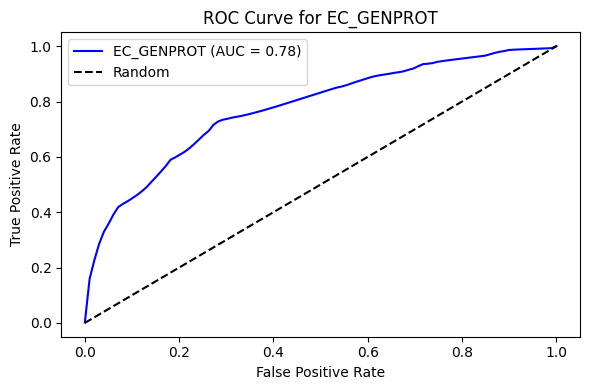

Fold 0 - Feature Importances: 3 [0.62933027 0.25922436 0.11144538]
Fold 1 - Feature Importances: 3 [0.60659718 0.24851125 0.14489157]
Fold 2 - Feature Importances: 3 [0.6438569  0.24308131 0.11306179]
Fold 3 - Feature Importances: 3 [0.63570343 0.26624117 0.09805541]
Fold 4 - Feature Importances: 3 [0.65552521 0.22225021 0.12222458]


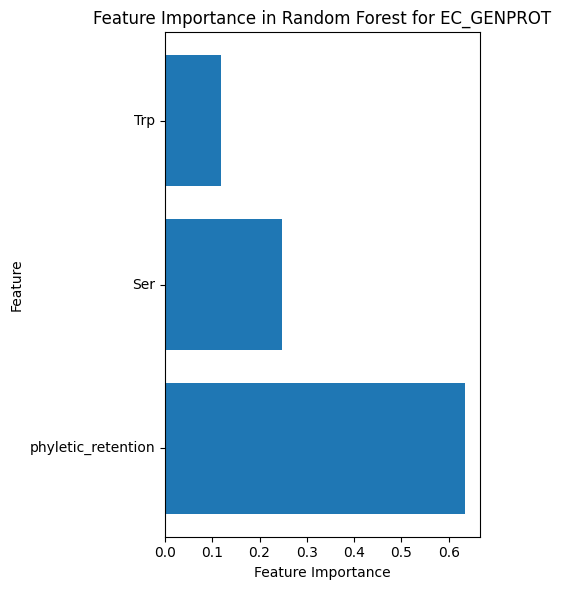

Running classifier EC_NO_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (3569, 28) (3569,)
Data saved successfully
Starting to find optimal number of features...
Features: 27, PPV (1%): 0.6857142857142857, PPV (5%): 0.4342857142857143
Features: 26, PPV (1%): 0.6857142857142857, PPV (5%): 0.43428571428571433
Features: 25, PPV (1%): 0.7428571428571429, PPV (5%): 0.4228571428571429
Features: 24, PPV (1%): 0.6285714285714286, PPV (5%): 0.41714285714285715
Features: 23, PPV (1%): 0.7142857142857142, PPV (5%): 0.44000000000000006
Features: 22, PPV (1%): 0.7142857142857142, PPV (5%): 0.4514285714285714
Features: 21, PPV (1%): 0.7142857142857142, PPV (5%): 0.42285714285714276
Features: 20, PPV (1%): 0.7428571428571429, PPV (5%): 0.41142857142857137
Features: 19, PPV (1%): 0.7714285714285714, PPV (5%): 0.45142857142857135
Features: 18, PPV (1%): 0.6571428571428571, PPV (5%): 0.42857142857142866
Features: 17, PPV (1%): 0.6, PPV (5%): 0.411

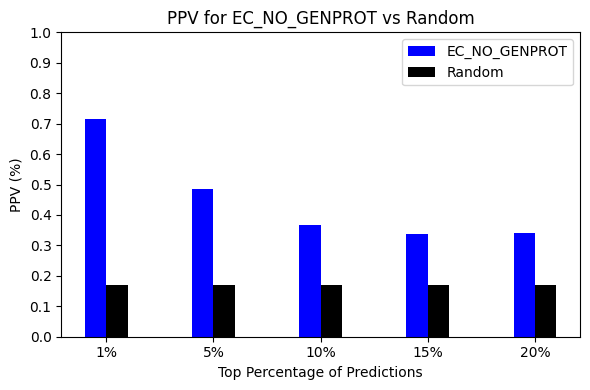

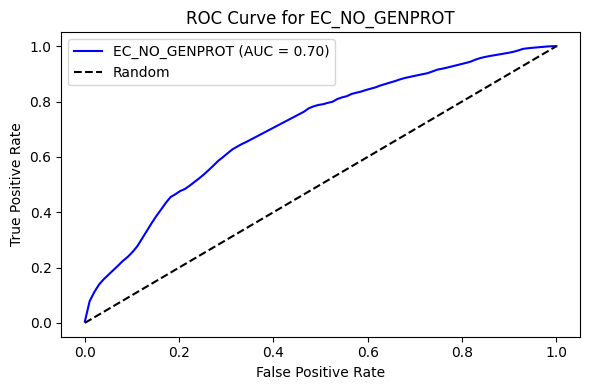

Fold 0 - Feature Importances: 5 [0.2686304  0.25162866 0.13693102 0.11576077 0.22704915]
Fold 1 - Feature Importances: 5 [0.25664105 0.24558496 0.18704848 0.1144992  0.19622631]
Fold 2 - Feature Importances: 5 [0.25061412 0.28196092 0.13799797 0.09037261 0.23905438]
Fold 3 - Feature Importances: 5 [0.27921124 0.25241471 0.1234243  0.10761266 0.23733709]
Fold 4 - Feature Importances: 5 [0.2544314  0.23959221 0.18410205 0.10707996 0.21479439]


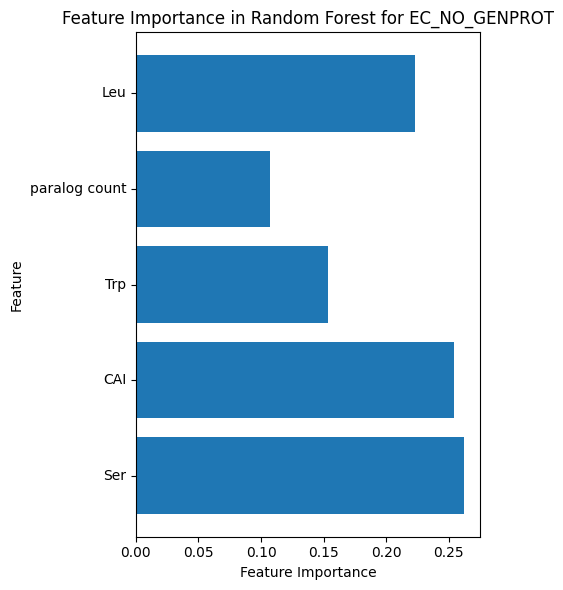

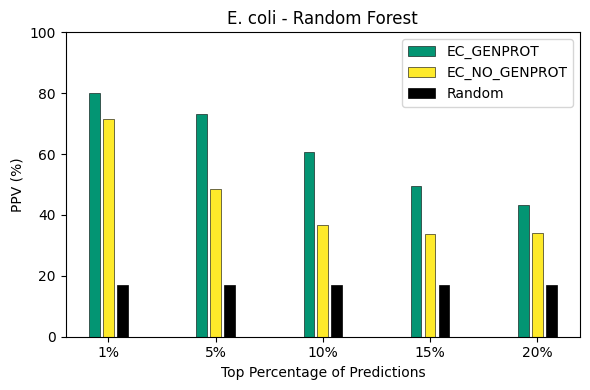

,1%,5%,10%,15%,20%,Number of Features
Classifier,,,,,,
EC_GENPROT,0.8,0.73,0.61,0.5,0.43,3
EC_NO_GENPROT,0.71,0.49,0.37,0.34,0.34,5


In [24]:
classifier_genprot_rf = EssentialityRandomForestClassifier('assets/coli_data.xls', CIMIM_EC_GENPROT, PERCENTILES, name='EC_GENPROT')
classifier_no_genprot_rf = EssentialityRandomForestClassifier('assets/coli_data.xls', CIMIM_EC_NO_GENPROT, PERCENTILES, name='EC_NO_GENPROT')

experiment = EssentialityExperiment("E. coli - Random Forest", [classifier_genprot_rf, classifier_no_genprot_rf])
experiment.run_experiment()
experiment.plot_and_save_comparative_results(PERCENTILES, colors=COLORS[1:])
experiment.plot_and_save_comparative_table(colors=COLORS[1:])